Ema's Quantum Computer

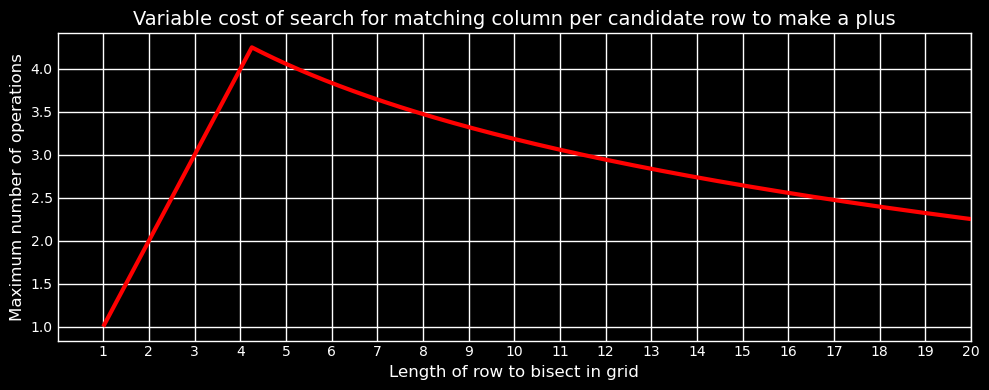

In [23]:

from colour import Color
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from math import log2

plt.rcParams["figure.figsize"] = [10, 4]
plt.rcParams["figure.autolayout"] = True
plt.style.use('fivethirtyeight')
plt.style.use('ggplot')
plt.style.use('dark_background')

n = 1000

def f(x, n):
    x = np.minimum(x, np.log2(n / (x + 1)))  # Use np.minimum for element-wise minimum
    return x

plt.xlabel('Length of row to bisect in grid', fontsize='12')
plt.ylabel('Maximum number of operations', fontsize='12')
plt.title(f'Variable cost of search for matching column per candidate row to make a plus', fontsize='14')

n = 100  # Example value for n
x = np.linspace(1, 30, 100_000)

plt.plot(x, f(x, n), color=Color('red').get_hex_l(), linewidth=3)

ax = plt.gca()
ax.set_xlim([0, 20])
ax.set_xticks(list(i for i in range(1,21)))

plt.show()


In [25]:
def populate(grid)->dict:
    d = {}
    dflat = {}
    def populate2():
        if L not in d:
            d[L] = {}
        inner_dict = d[L]
        if rownum not in inner_dict:
            inner_dict[rownum] = []
        inner_dict[rownum].append((right,L))
    def populate_flat():
        if rownum not in dflat:
            dflat[rownum] = []
        dflat[rownum].append((right,L))
    for rownum,row in enumerate(grid):
        # print(f'entering row {rownum}, {row}')
        start = False
        starti = -1
        for i,val in enumerate(row):
            if val == 'G':
                if not start:
                    start = True
                    starti = i
            else:
                if start:    # here we find our end point 
                    start = False
                    L = i - starti
                    right = i - 1
                    # print(f'L is {L}, right is {right}')
                    populate2()
        else:
            if start:
                L = i - starti + 1
                right = i
                # print(f'L is {L}, right is {right}')
                populate2()
    return d,dflat

In [26]:
def populate_2d_dict(d1)->dict:
    '''
    Helperfunction that creates a separate 2d_dict that points to 
    the same lists as populate_2d_dict with swapped inner and outer keys
    '''
    d2 = {}
    for L, d in d1.items():
        for row,inner_dict in d.items():
            if row not in d2:
                d2[row] = {}
            d2[row][L] = d1[L][row]
    return d2

In [27]:
def print_2d_dict(d,outerkey='key1',innerkey='key2', title = 'printing 2d dict'):
    print(title)
    for key,inner_dict in d.items():
        print(outerkey,key)
        for row,rightlist in inner_dict.items():
            print(innerkey,row,'list',rightlist)
    print('*******************')

In [28]:
def print_1d_dict(d,title = '1d dict'):
    print('printing', title)
    for key, value in d.items():
        print(key, value)
    print('*******************')

In [29]:
def populate_rowdict(index_d)->dict:
    '''
    Helper function that stores the iteratively merged sorted lists
    for each row
    Takes as input populate_2d_dict output
    '''
    d = {}
    for row in index_d:
        d[row] = []
    return d

In [30]:
def populate_rowdict_sorted_keys(dict_2d):
    '''
    Helper function for populate_2d_dict
    takes in output of populate_2d_dict
    stores the sorted list of remaining un-merged keys
    Pop from lists in this dictionary to get the next key 
    to merge into populate_rowdict's dict
    '''
    d = {}
    for row,inner_dict in dict_2d.items():
        d[row] = sorted(inner_dict.keys()) # keys would be L from the dict_2d that has row -> L -> [right,...]
    return d

In [55]:
from heapq import merge
def merge_into_rowdict(L, rownum, irowdict_2d, rowdict, rowdict_keys):    # L, rownumber, irow or icol, rowdict, rowdict keys
    '''
    Function to merge from row to rowdict using keys from rowdict_index
    '''
    inner_dict_L_rightlist = irowdict_2d[rownum]    #at inner rowdict to get merge items
    L_sorted = rowdict_keys[rownum]    # get the sorted keys remaining
    print('merging outside while loop with keys: ',L_sorted, 'rownum',rownum)
    while L_sorted and L <= L_sorted[-1]:
        key = L_sorted.pop()
        print('inside merge_into_rowdict, key = ',key,'previous rowdict', rowdict[rownum],'', inner_dict_L_rightlist[key])
        rowdict[rownum] = list(merge(rowdict[rownum], inner_dict_L_rightlist[key])) #merge two lists of (x,y) tuples
        print(rowdict[rownum], 'merge output')
        del inner_dict_L_rightlist[key]    # this deletes the key reference in the inner dict 
    else:
        print('merge ended for L = ', L,'keys', L_sorted,'to_bisect list',rowdict[rownum])
        

In [64]:
from bisect import bisect_left
from collections import deque
from heapq import merge
from itertools import tee
def twoPluses(grid):
    n = len(grid)
    m = len(grid[0])
    dplus = []

    drow, drowflat = populate(grid)
    dcol, dcolflat = populate(zip(*grid))

    irow = populate_2d_dict(drow)
    icol = populate_2d_dict(dcol)

    merge_rows = populate_rowdict(irow)
    merge_cols = populate_rowdict(icol)

    merge_rows_keys = populate_rowdict_sorted_keys(irow)
    merge_cols_keys = populate_rowdict_sorted_keys(icol)

    #find each centroid that is a valid + and enter into dict
    def search_at_L(search_descending, L, dplus, d_in, i_in, merge_dict, merge_dict_keys):
        def search_in(L, fixed_row, fixed_column):    # searching across fixed column for fixed row index
            merge_into_rowdict(L, fixed_column, i_in, merge_dict, merge_dict_keys) # after this, merge_dict has everything we ened to do a search.
            search_arr = merge_dict[fixed_column]
            search_tuple_index = bisect_left(search_arr,fixed_row, key = lambda x:x[0])
            if search_tuple_index == len(search_arr):
                print('search index out of bounds: ', search_tuple_index)
                return
            search_tuple = search_arr[search_tuple_index]
            search_right = search_tuple[0]
            search_length = search_tuple[1]
            L_2 = L // 2
            left_bound = fixed_row - L_2
            left_bound2 = search_right - search_length
            print('row',fixed_row,'col',fixed_column,'search_arr',search_arr,'search_tuple_index',search_tuple_index,'search_tuple',search_tuple)
            print('L',L,'left1',left_bound,'left2',left_bound2)

            if left_bound2 <= left_bound:
                print('Valid Plus at centroid: ',fixed_row,fixed_column,L)
                dplus.append((fixed_row, fixed_column, L))
            elif left_bound2 <= fixed_row:
                new_L = 2 * (fixed_row - left_bound2) + 1
                print('Valid Plus at centroid',fixed_row,fixed_column,new_L)
                dplus.append((fixed_row, fixed_column, L))
            else:
                print('no valid plus')


        if L not in d_in:
            print('no L')
            return
        search_descending.append(L)
        if L % 2 == 0:    # necessary because even lengths are not valid +, just encoded this way for global simplicity
            print('adjusting L')
            L -= 1    # L will always be odd so L//2 will work
        L_2 = L//2

        for L_scope in search_descending:
            L_neg = L - L_scope
            if L_neg:
                paddings_tuple = (L_neg, 0)    # L_neg will always be negative or 0 so ex. (-2, 0) for a scope of 5 and L of 3
            else:
                paddings_tuple = (0,)

            inner_dict = d_in[L_scope]    # inner dict that contains key row and value right with length L i.e. 8 7 6 5
            for row, rightlist in inner_dict.items():    #for each row get the list of valid rights of length L_scope
                for right_tuple in rightlist:    # tuple (right, L)
                    for padding in paddings_tuple:    # example padding -2,0
                        right_temp = right_tuple[0] + padding
                        column = right_temp - L_2    # candidate column for centroid at (row,column) to make a plus
                        print(f'L {L} row {row} rightlist {rightlist} right {right_temp} row/column ({row}, {column})')
                        search_in(L, row, column)

            

            
            
            # # nested for loop over every right - runtime is linear because of key access and constant bounds for loops 1 and 3
            # for row, rightlist in inner_dict.items():
            #     for right in rightlist:
            #         for adj in adjustment:
            #             # print(right,adj,right+adj)
            #             right_temp = right[0] + adj
            #             column = right_temp - L//2
            #             print(f'L {L} row {row} rightlist {rightlist} right {right_temp} column {column}')
            #             search_in(L, column)
            #             # centroid at row,column now search in d_out for a match where column is fixed and right is variable on row


        

    # print('printing dictionaries')
    # print_2d_dict(drow,'L','row')
    # print_2d_dict(irow,'row','L')
    # print_1d_dict(merge_rows, 'merge rows')  
    print_1d_dict(merge_rows_keys,'keys')

    # print('doing dcol')
    # print_2d_dict(dcol,'L','col')
    # print_2d_dict(icol,'col','L')
    # print_1d_dict(merge_cols, 'merge rows')  
    print_1d_dict(merge_cols_keys,'keys')
    
    max1 = 0
    max2 = 0
    longest = sorted(list(drow.keys() | dcol.keys()))
    search_descending_rows = []
    search_descending_cols = []
    row_keys = sorted(list(drow.keys()))
    col_keys = sorted(list(dcol.keys()))

    # rqueue = deque([row_keys.pop()])
    # cqueue = deque([col_keys.pop()]) # Using deque because less memory overhead

    # print(rqueue,cqueue)

    print_1d_dict(merge_cols, 'merge cols')  
    print_1d_dict(merge_rows, 'merge rows')
    print_2d_dict(irow,'row','L')
    print_2d_dict(icol,'col','L')

    while longest:    # for each L from highest
        L = longest.pop()
        print('L decremented to: ', L)
        print('search at rows')
        search_at_L(search_descending_rows, L,dplus, drow, icol, merge_cols, merge_cols_keys)    # search drow[L] for all rights of length L
        print('search_at_cols')
        search_at_L(search_descending_cols, L,dplus, dcol, irow, merge_rows, merge_rows_keys)
        print('**************************')


    print_1d_dict(merge_rows, 'merge rows')        
    print_1d_dict(merge_cols, 'merge cols')  
    print_2d_dict(irow,'row','L')
    print_2d_dict(icol,'col','L')
    print(dplus)


In [69]:
twoPluses(grid)

printing keys
0 [6]
2 [6]
4 [6]
1 [1]
3 [1, 2]
*******************
printing keys
0 [5]
4 [5]
1 [1, 3]
2 [1]
3 [1]
5 [1]
*******************
printing merge cols
0 []
4 []
1 []
2 []
3 []
5 []
*******************
printing merge rows
0 []
2 []
4 []
1 []
3 []
*******************
printing 2d dict
row 0
L 6 list [(5, 6)]
row 2
L 6 list [(5, 6)]
row 4
L 6 list [(5, 6)]
row 1
L 1 list [(0, 1), (4, 1)]
row 3
L 1 list [(4, 1)]
L 2 list [(1, 2)]
*******************
printing 2d dict
col 0
L 5 list [(4, 5)]
col 4
L 5 list [(4, 5)]
col 1
L 1 list [(0, 1)]
L 3 list [(4, 3)]
col 2
L 1 list [(0, 1), (2, 1), (4, 1)]
col 3
L 1 list [(0, 1), (2, 1), (4, 1)]
col 5
L 1 list [(0, 1), (2, 1), (4, 1)]
*******************
L decremented to:  6
search at rows
adjusting L
L 5 row 0 rightlist [(5, 6)] right 4 row/column (0, 2)
merging outside while loop with keys:  [1] rownum 2
merge ended for L =  5 keys [1] to_bisect list []
search index out of bounds:  0
L 5 row 0 rightlist [(5, 6)] right 5 row/column (0, 3)
merg

In [68]:
grid = [
'GGGGGG',
'GBBBGB',
'GGGGGG',
'GGBBGB',
'GGGGGG',
]

In [28]:
import timeit

list_time = timeit.timeit('["a", "b", "c", "d"]', number=1000000)
tuple_time = timeit.timeit('("a", "b", "c", "d")', number=1000000)

print(f"List creation time: {list_time}")
print(f"Tuple creation time: {tuple_time}")


List creation time: 0.04958500000066124
Tuple creation time: 0.01015340001322329


In [37]:
import timeit

# Timing "if L:"
time_if_L = timeit.timeit('L = 2\nif L < 3:\n pass', number=1000000)

# Timing "if L == 0:"
time_if_L_eq_0 = timeit.timeit('L = 2\nif L == 0:\n pass', number=1000000)

print(f"Timing for 'if L:': {time_if_L} seconds")
print(f"Timing for 'if L == 0:': {time_if_L_eq_0} seconds")


Timing for 'if L:': 0.01944579999690177 seconds
Timing for 'if L == 0:': 0.01678140000149142 seconds


printing merge cols
0 []
4 []
1 []
2 []
3 []
5 []
*******************
printing merge rows
0 []
2 []
4 []
1 []
3 []
*******************
printing 2d dict
row 0
L 6 list [(5, 6)]
row 2
L 6 list [(5, 6)]
row 4
L 6 list [(5, 6)]
row 1
L 1 list [(0, 1), (4, 1)]
row 3
L 1 list [(4, 1)]
L 2 list [(1, 2)]
*******************
printing 2d dict
col 0
L 5 list [(4, 5)]
col 4
L 5 list [(4, 5)]
col 1
L 1 list [(0, 1)]
L 3 list [(4, 3)]
col 2
L 1 list [(0, 1), (2, 1), (4, 1)]
col 3
L 1 list [(0, 1), (2, 1), (4, 1)]
col 5
L 1 list [(0, 1), (2, 1), (4, 1)]

printing merge rows
0 [(5, 6)]
2 [(5, 6)]
4 [(5, 6)]
1 []
3 []
*******************
printing merge cols
0 [(4, 5)]
4 [(4, 5)]
1 [(0, 1), (4, 3)]
2 []
3 []
5 [(0, 1), (2, 1), (4, 1)]
*******************
printing 2d dict
row 0
row 2
row 4
row 1
L 1 list [(0, 1), (4, 1)]
row 3
L 1 list [(4, 1)]
L 2 list [(1, 2)]
*******************
printing 2d dict
col 0
col 4
col 1
col 2
L 1 list [(0, 1), (2, 1), (4, 1)]
col 3
L 1 list [(0, 1), (2, 1), (4, 1)]
col 5
*******************
[(0, 2, 5), (4, 2, 5), (0, 0, 1), (0, 5, 1), (2, 0, 1), (2, 5, 1), (4, 0, 1), (4, 5, 1), (3, 0, 1), (3, 1, 1), (0, 0, 1), (0, 5, 1), (2, 0, 1), (2, 5, 1), (4, 0, 1), (4, 5, 1), (3, 0, 1), (3, 1, 1), (1, 0, 1), (1, 4, 1), (3, 4, 1), (0, 0, 1), (0, 4, 1), (4, 0, 1), (4, 4, 1), (1, 2, 1), (1, 4, 1), (1, 0, 1), (2, 0, 1), (2, 2, 1), (2, 4, 1), (3, 0, 1), (3, 2, 1), (3, 4, 1), (5, 0, 1), (5, 2, 1), (5, 4, 1)]